In [43]:
!pip install backtrader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import backtrader as bt 
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import datetime
import yfinance as yf
from matplotlib import pyplot as plt

In [45]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

class BB_RSI(bt.Strategy):

    params = (('BB_MA', 20), ('BB_SD', 2))

    def __init__(self):
        self.order = None
        self.stopprice = None
        self.closepos = None
        self.bb = bt.indicators.BollingerBands(self.data, period=self.params.BB_MA, devfactor=self.params.BB_SD)
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=14)


    def log(self, txt, doprint=True):
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status == order.Completed:
            if order.isbuy():
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell():
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]:
            self.log('Order Rejected/Margin')

        self.order = None
    

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self):
        if self.order:
            return
        
        if self.position.size == 0:
                if (self.data.close[-1] > self.bb.lines.top[-1]) and (self.data.close[0] <= self.bb.lines.top[0] and self.rsi > 60 ):
                    self.order = self.sell()
                    self.stopprice = self.bb.lines.top[0]
                    self.closepos = self.buy(exectype=bt.Order.Stop, price=self.stopprice)

                elif (self.data.close[-1] < self.bb.lines.bot[-1]) and (self.data.close[0] >= self.bb.lines.bot[0] and self.rsi < 40):
                    self.order = self.buy()
                    self.stopprice = self.bb.lines.bot[0]
                    self.closepos = self.sell(exectype=bt.Order.Stop, price=self.stopprice)

        elif self.position.size > 0:
            if (self.data.close[-1] < self.bb.lines.mid[-1]) and (self.data.close[0] >= self.bb.lines.mid[0] and self.rsi > 50):
                self.closepos = self.close()
        elif self.position.size < 0:
            if (self.data.close[-1] > self.bb.lines.mid[-1]) and (self.data.close[0] <= self.bb.lines.mid[0] and self.rsi < 50):
                self.closepos = self.close()

In [46]:
if __name__ == '__main__':

    cerebro = bt.Cerebro()

    datapath = 'SONATSOFTW.NS.csv'
    feed = bt.feeds.PandasData(dataname=yf.download('SONATSOFTW.NS', '2017-01-01', '2022-10-12'))
    cerebro.adddata(feed)

    cerebro.addstrategy(BB_RSI)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=.0001)

    cerebro.addsizer(bt.sizers.PercentSizer, percents=85)  

[*********************100%***********************]  1 of 1 completed


In [47]:
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sr')  
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='dd')  
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='ar')
    cerebro.addanalyzer(btanalyzers.Returns, _name='r') 
    cerebro.addanalyzer(btanalyzers.SQN, _name='sqn')    
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='ta') 
    cerebro.addanalyzer(btanalyzers.PyFolio, _name='pf')

In [48]:
    bb = cerebro.run()
    bb1 = bb[0]
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 

2017-03-17--BUY   price: 136.125, value: 85305.50371638917, commission: 8.530550371638917
2017-03-17--SELL   price: 134.96686965135726, value: 85305.50371638917, commission: 8.457973774569895
2017-03-17--CLOSE   Gross P/L: -725.765970690223, Net P/L: -742.7544948364317
2017-03-24--BUY   price: 129.0, value: 85135.87045846607, commission: 8.513587045846608
2017-03-24--SELL   price: 126.21380524027117, value: 85135.87045846607, commission: 8.329707110857205
2017-03-24--CLOSE   Gross P/L: -1838.799349894036, Net P/L: -1855.6426440507398
2017-05-26--BUY   price: 112.5, value: 82984.99182843362, commission: 8.298499182843361
2017-06-19--SELL   price: 118.5374984741211, value: 82984.99182843362, commission: 8.743851859767023
2017-06-19--CLOSE   Gross P/L: 4453.526769236617, Net P/L: 4436.484418194006
2017-08-09--BUY   price: 117.03749847412108, value: 86423.91869266647, commission: 8.642391869266648
2017-08-09--SELL   price: 117.03749847412108, value: 86423.91869266647, commission: 8.6423918

In [49]:
print('Sharpe Ratio:', bb1.analyzers.sr.get_analysis())

Sharpe Ratio: OrderedDict([('sharperatio', 0.9115974445633444)])


In [50]:
print('Drawdown:', bb1.analyzers.dd.get_analysis())

Drawdown: AutoOrderedDict([('len', 7), ('drawdown', 2.006066944988973), ('moneydown', 5549.419587788638), ('max', AutoOrderedDict([('len', 659), ('drawdown', 21.46508832165792), ('moneydown', 54994.19696602531)]))])


In [51]:
print('Annual Return:', bb1.analyzers.ar.get_analysis())
print('Returns:', bb1.analyzers.r.get_analysis())

Annual Return: OrderedDict([(2017, 0.5139683557488774), (2018, 0.42085804116439207), (2019, 0.06953863005730354), (2020, -0.08950585512708487), (2021, 0.12818008432294237), (2022, 0.14704849885213944)])
Returns: OrderedDict([('rtot', 0.9972526653167244), ('ravg', 0.0006983562082049891), ('rnorm', 0.19242108378094225), ('rnorm100', 19.242108378094226)])


In [52]:
print('SQN:', bb1.analyzers.sqn.get_analysis())

SQN: AutoOrderedDict([('sqn', 1.7405036784792431), ('trades', 56)])


In [53]:
print('Trade Analyzer:', bb1.analyzers.ta.get_analysis())

Trade Analyzer: AutoOrderedDict([('total', AutoOrderedDict([('total', 57), ('open', 1), ('closed', 56)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 3)])), ('lost', AutoOrderedDict([('current', 1), ('longest', 14)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 153438.92841840966), ('average', 2739.9808646144584)])), ('net', AutoOrderedDict([('total', 151421.36159764486), ('average', 2703.9528856722295)]))])), ('won', AutoOrderedDict([('total', 17), ('pnl', AutoOrderedDict([('total', 244577.43351941532), ('average', 14386.907854083254), ('max', 57291.96967993781)]))])), ('lost', AutoOrderedDict([('total', 39), ('pnl', AutoOrderedDict([('total', -93156.07192177056), ('average', -2388.6172287633476), ('max', -8002.961941142639)]))])), ('long', AutoOrderedDict([('total', 21), ('pnl', AutoOrderedDict([('total', 158533.30099184116), ('average', 7549.2048091352935), ('won', AutoOrderedDict([('total', 188119.3541285192), ('average', 

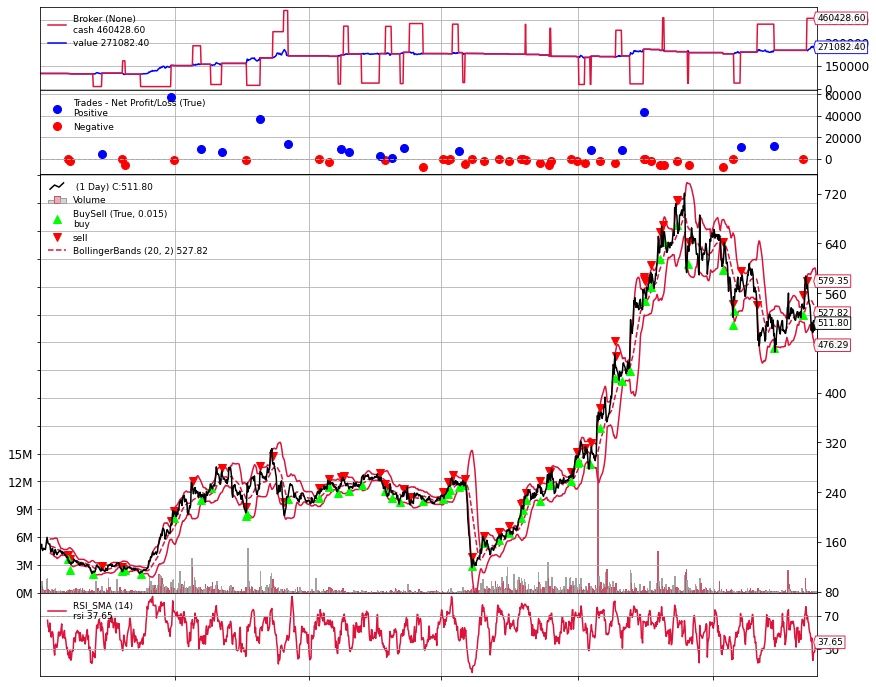

[[<Figure size 864x720 with 5 Axes>]]

In [54]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)